# Imports

In [294]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import datetime
import inflection
import scikitplot as skpt

In [152]:
from scipy import stats
from imblearn.combine import SMOTETomek
from boruta import BorutaPy
from sklearn.utils import shuffle
# from ydata_profiling import ProfileReport

In [235]:
from sklearn.model_selection import StratifiedKFold, train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score,recall_score,brier_score_loss, classification_report
from sklearn.metrics import roc_curve,precision_recall_curve,confusion_matrix,f1_score,cohen_kappa_score,auc,roc_auc_score
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

In [154]:
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier



In [405]:
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

import warnings
warnings.filterwarnings("ignore")

# Helper Functions

In [73]:
sns.set()

In [74]:
def ml_metrics( model_name, y, yhat):
    precision = precision_score(y, yhat)
    recall = recall_score(y, yhat)
    accuracy = accuracy_score(y, yhat)
    f1_value = f1_score(y, yhat)
    cohen_kappa_value = cohen_kappa_score(y, yhat)
    return pd.DataFrame({'Model Name': model_name, 
                        'precision': precision,
                        'recall': recall,
                        'accuracy': accuracy,
                        'f1-score': f1_value,
                        'cohen-kappa': cohen_kappa_value}, index = [0])

In [319]:
def ml_cross_validation(model_name, model, k_fold, X, y, threshold):
    folder = StratifiedKFold(n_splits = k_fold)

    measures = pd.DataFrame()
    for train_index, test_index in folder.split(X, y):
        x_train_fold, x_test_fold = X.iloc[train_index,:], X.iloc[test_index,:]
        y_train_fold, y_test_fold = y.iloc[train_index,:], y.iloc[test_index,:]

        model.fit(x_train_fold,y_train_fold.values.ravel())

        if threshold is None:
            y_hat = model.predict(x_test_fold)
        else:
            y_hat = model.predict_proba(x_test_fold)[:,1]
            y_hat[y_hat >= threshold] = 1
            y_hat[y_hat < threshold] = 0
        measure = ml_metrics( model_name, y_test_fold, y_hat)
        measures = pd.concat( [ measures, measure], axis = 0, ignore_index = True)
    return measures

In [76]:
def cramer_v(x, y):
    cm = pd.crosstab( x, y).to_numpy()
    n = cm.sum()
    r, k = cm.shape

    chi2 = stats.chi2_contingency( cm )[0]

    # correção bias V de Cramer
    chi2corr = max(0, chi2 - (k-1)*(r - 1) / (n-1))
    kcorr = k - (k-1)**2 / (n-1)
    rcorr = r - (r-1)**2 / (n-1)

    v = np.sqrt( (chi2corr / n) / (min(kcorr-1, rcorr-1) ) )
    return v

In [77]:
data_path = '../data/'

# Load Data

In [78]:
df = pd.read_csv(data_path + 'raw/churn.csv')
df = df.drop(['RowNumber'], axis = 1)
df.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15634602,Hargrave,619,France,Female,42,2,0.000,1,1,1,101348.880,1
1,15647311,Hill,608,Spain,Female,41,1,83807.860,1,0,1,112542.580,0
2,15619304,Onio,502,France,Female,42,8,159660.800,3,1,0,113931.570,1
3,15701354,Boni,699,France,Female,39,1,0.000,2,0,0,93826.630,0
4,15737888,Mitchell,850,Spain,Female,43,2,125510.820,1,1,1,79084.100,0


## Data Dimension

In [79]:
print('Number of Rows: {} \nNumber of Columns: {}'.format(df.shape[0], df.shape[1]))

Number of Rows: 10000 
Number of Columns: 13


## Check NaN Values

In [80]:
df.isna().sum()

CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

## Check Data Types

In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       10000 non-null  int64  
 1   Surname          10000 non-null  object 
 2   CreditScore      10000 non-null  int64  
 3   Geography        10000 non-null  object 
 4   Gender           10000 non-null  object 
 5   Age              10000 non-null  int64  
 6   Tenure           10000 non-null  int64  
 7   Balance          10000 non-null  float64
 8   NumOfProducts    10000 non-null  int64  
 9   HasCrCard        10000 non-null  int64  
 10  IsActiveMember   10000 non-null  int64  
 11  EstimatedSalary  10000 non-null  float64
 12  Exited           10000 non-null  int64  
dtypes: float64(2), int64(8), object(3)
memory usage: 1015.8+ KB


## Check Churn

In [82]:
n_churn = df.loc[df['exited'] == 1].shape[0]
n_non_churn = df.loc[df['exited'] == 0].shape[0]

print('Number of Churns: {}\nNumber of Non-Churns: {}'.format(n_churn,n_non_churn))
df['exited'].value_counts(normalize = True)

Number of Churns: 2037
Number of Non-Churns: 7963


0   0.796
1   0.204
Name: Exited, dtype: float64

The dataset is **UNBALANCED**

In [83]:
cols_old = df.columns

snakecase = lambda x: inflection.underscore(x)
cols_new = list( map( snakecase, cols_old))

# rename

df.columns = cols_new
df.to_parquet(data_path + 'processed/churn.parquet', index = False)

# Load parquet

In [84]:
df = pd.read_parquet(data_path + 'processed/churn.parquet')

# Descriptive Analysis

## Numerical Attributes

In [85]:
numerical_attributes = df.select_dtypes(include=['int64','float64'])

t_mean = pd.DataFrame(numerical_attributes.apply( np.mean )).T
t_median = pd.DataFrame(numerical_attributes.apply( np.median )).T
t_std = pd.DataFrame(numerical_attributes.apply( np.std )).T
t_min = pd.DataFrame(numerical_attributes.apply( np.min )).T
t_max = pd.DataFrame(numerical_attributes.apply( np.max )).T
t_skew = pd.DataFrame(numerical_attributes.apply( lambda x: x.skew() )).T
t_kurtosis = pd.DataFrame(numerical_attributes.apply( lambda x: x.kurtosis() )).T

num_metrics = pd.concat( [t_min,t_max,t_mean, t_median, t_std,t_skew,t_kurtosis]).T.reset_index()
num_metrics.columns = ['attributes','min','max','mean','median','std','skew','kurtosis']
num_metrics

,attributes,min,max,mean,median,std,skew,kurtosis
0,customer_id,15565701.000,15815690.000,15690940.569,15690738.000,71932.589,0.001,-1.196
1,credit_score,350.000,850.000,650.529,652.000,96.648,-0.072,-0.426
2,age,18.000,92.000,38.922,37.000,10.487,1.011,1.395
3,tenure,0.000,10.000,5.013,5.000,2.892,0.011,-1.165
4,balance,0.000,250898.090,76485.889,97198.540,62394.285,-0.141,-1.489
5,num_of_products,1.000,4.000,1.530,1.000,0.582,0.746,0.583
6,has_cr_card,0.000,1.000,0.706,1.000,0.456,-0.902,-1.187
7,is_active_member,0.000,1.000,0.515,1.000,0.500,-0.060,-1.997
8,estimated_salary,11.580,199992.480,100090.240,100193.915,57507.617,0.002,-1.182
9,exited,0.000,1.000,0.204,0.000,0.403,1.472,0.166


We have most of the columns with a left-side distribution (not a perfect normal dist), with low peak (kurtosis < 0)

In [86]:
num_cols = ['credit_score', 'age', 'tenure', 'balance','num_of_products', 'has_cr_card', 'is_active_member', 'estimated_salary','exited']

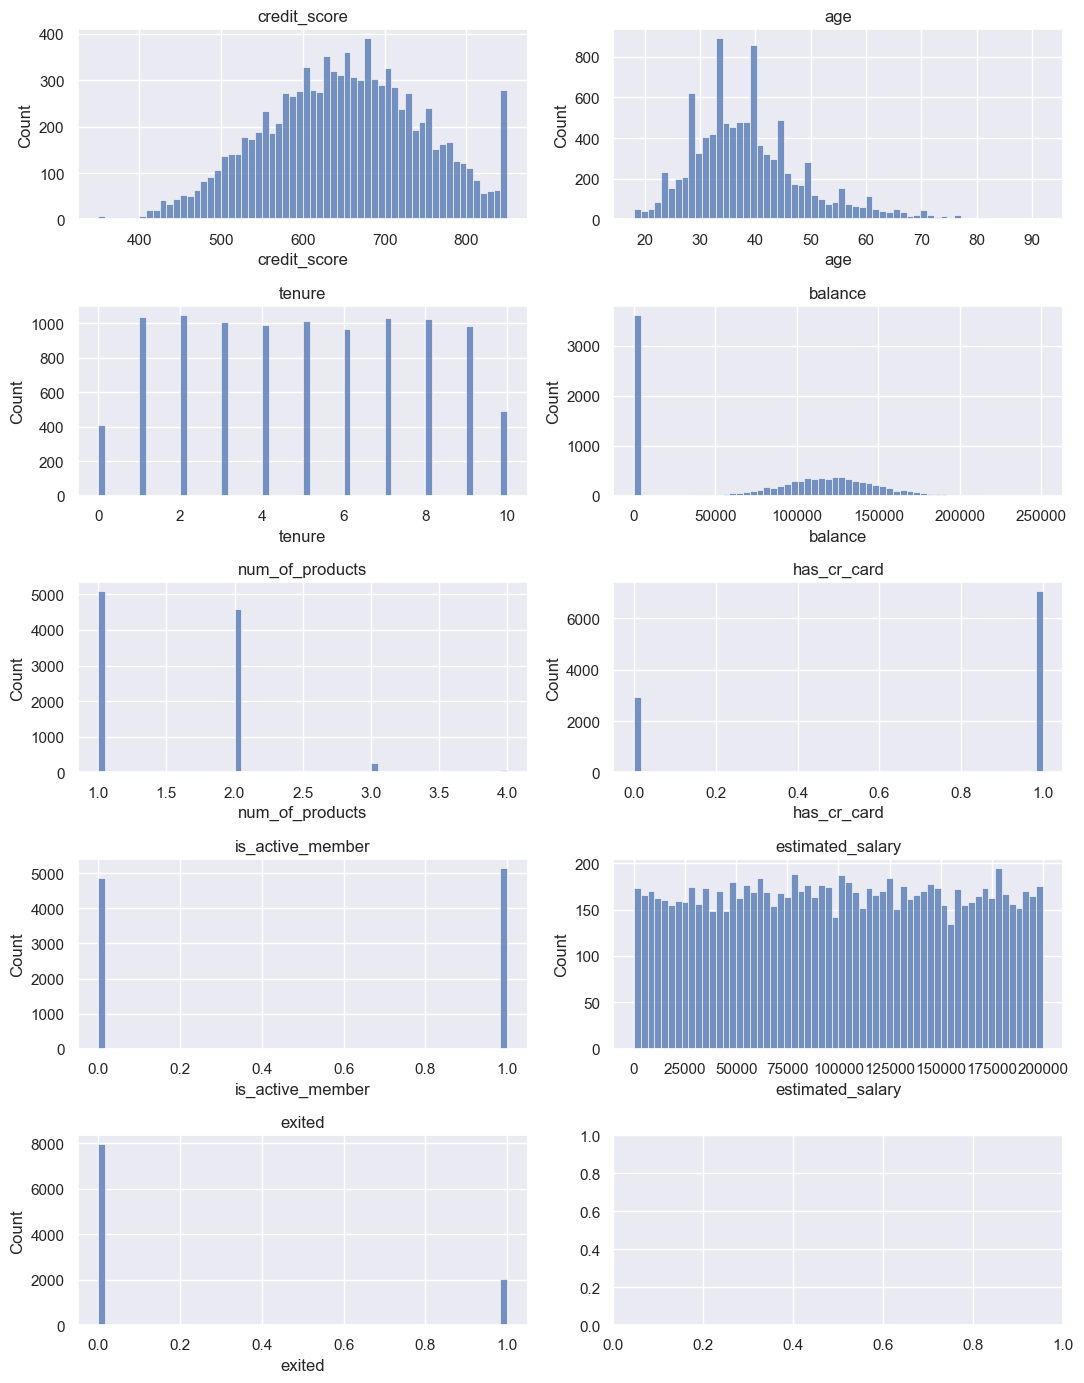

In [87]:
fig, axes = plt.subplots(int(len(num_cols)/2)+1,2, figsize=(11,14))

for i, coluna in enumerate(num_cols):
    pos_x, pos_y = divmod(i,2)
    # print(pos_x, pos_y)
    sns.histplot(data = df, x = coluna, bins = 60, ax = axes[pos_x, pos_y]);
    axes[pos_x, pos_y].set_title(coluna)

plt.tight_layout()

## Categorical Attributes

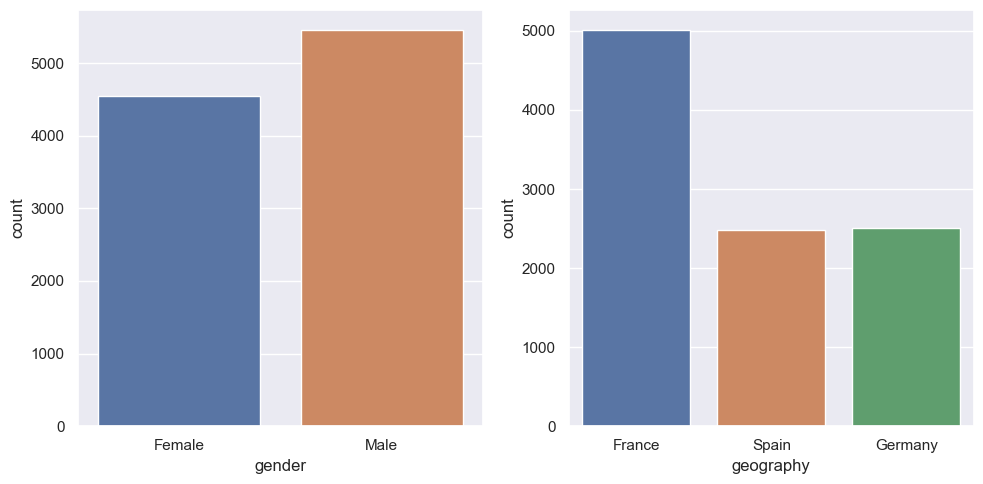

In [88]:
fig, axes = plt.subplots(1,2, figsize=(10,5))

sns.countplot(data = df, x = 'gender', ax = axes[0]);
sns.countplot(data = df, x = 'geography', ax = axes[1]);

plt.tight_layout()

# Feature Engineering

- `qualification`: "bad debt", "good debt" and "excellent debt"
- `age_range`: "young", "adult" and "elder"
- `mean_spent_product`= "balance" / "num_of_products"
- `proportion_debt`= "balance" / "estimated_salary"
- `kind_balance`: "zero" and "non_zero"
- `kind_salary`: "low", "mid" and "high"

In [89]:
df1 = df.copy()
df1.head()

,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,15634602,Hargrave,619,France,Female,42,2,0.000,1,1,1,101348.880,1
1,15647311,Hill,608,Spain,Female,41,1,83807.860,1,0,1,112542.580,0
2,15619304,Onio,502,France,Female,42,8,159660.800,3,1,0,113931.570,1
3,15701354,Boni,699,France,Female,39,1,0.000,2,0,0,93826.630,0
4,15737888,Mitchell,850,Spain,Female,43,2,125510.820,1,1,1,79084.100,0


In [93]:
hist_cols = ['credit_score','age','balance','estimated_salary']

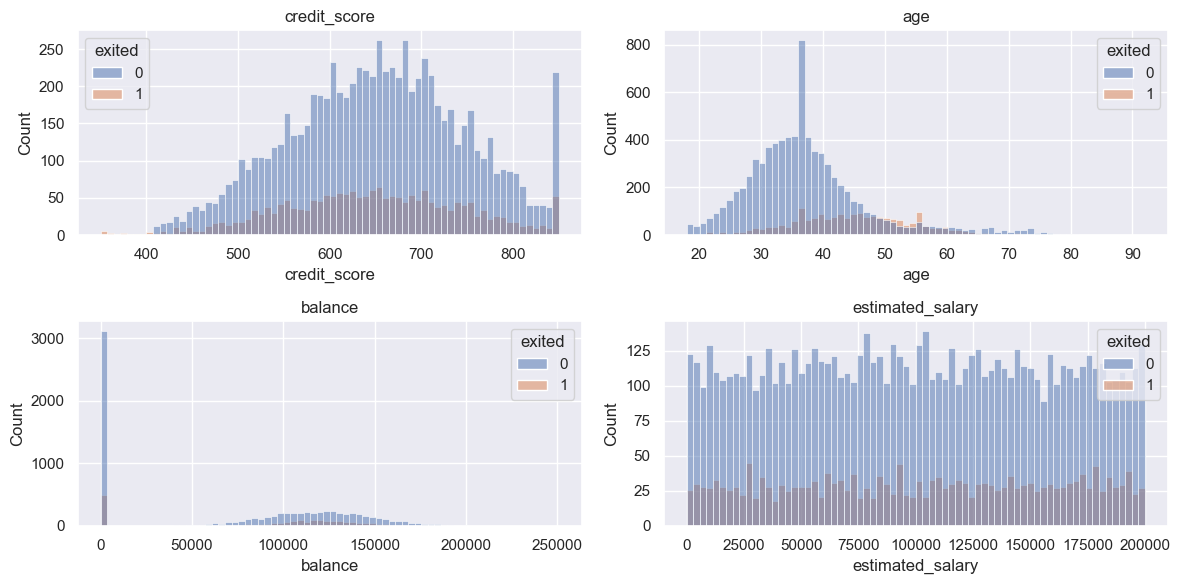

In [94]:
qty_rows = int(len(hist_cols)/2)
fig, axes = plt.subplots(qty_rows,2, figsize=(12,qty_rows*3))

for i, coluna in enumerate(hist_cols):
    pos_x, pos_y = divmod(i,2)
    # print(pos_x, pos_y)
    sns.histplot(data = df2, x = coluna, hue = 'exited',bins = 70, ax = axes[pos_x, pos_y]);
    axes[pos_x, pos_y].set_title(coluna)

plt.tight_layout()

c:\Users\pedro\miniconda3\lib\site-packages\seaborn\distributions.py:2142: UserWarning: `displot` is a figure-level function and does not accept the ax= parameter. You may wish to try histplot.
  warnings.warn(msg, UserWarning)


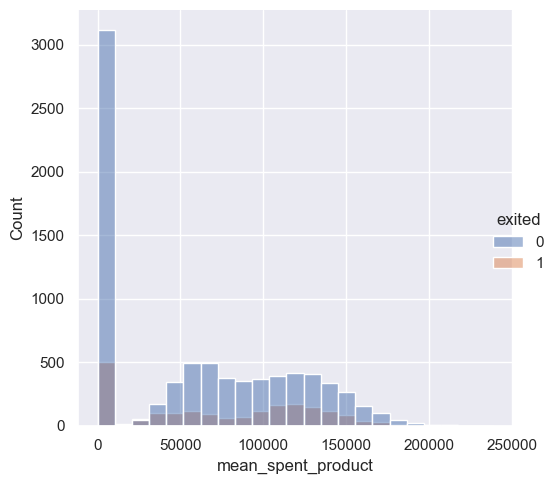

In [95]:
sns.displot(data = df2,x='mean_spent_product', hue='exited', ax = axes)
plt.tight_layout()

In [96]:
# sns.displot(data = df2,x='proportion_debt', hue='exited', ax = axes)
# plt.tight_layout()

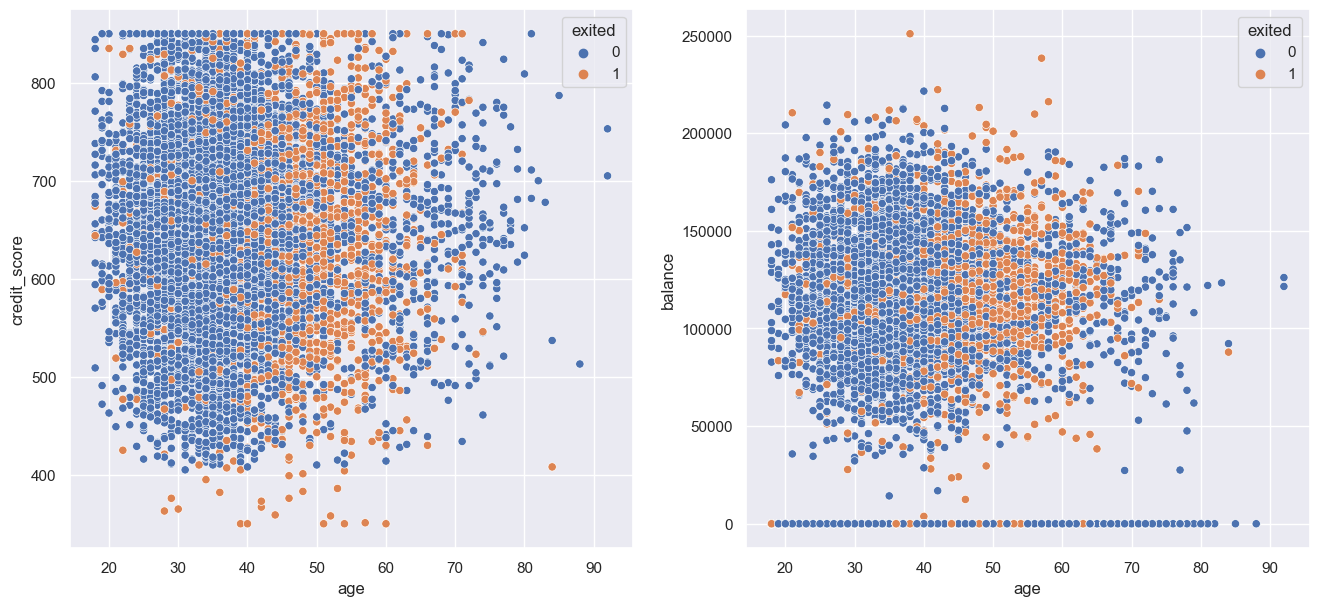

In [97]:
fig, axes = plt.subplots(1,2,figsize=(16,7))

sns.scatterplot(data = df2, x = 'age', y = 'credit_score', hue = 'exited',ax = axes[0]);
sns.scatterplot(data = df2, x = 'age', y = 'balance', hue = 'exited',ax = axes[1]);

In [98]:
cat_cols = df2.select_dtypes(include=['object']).columns.tolist()
cat_cols.remove('surname')
len(cat_cols)

6

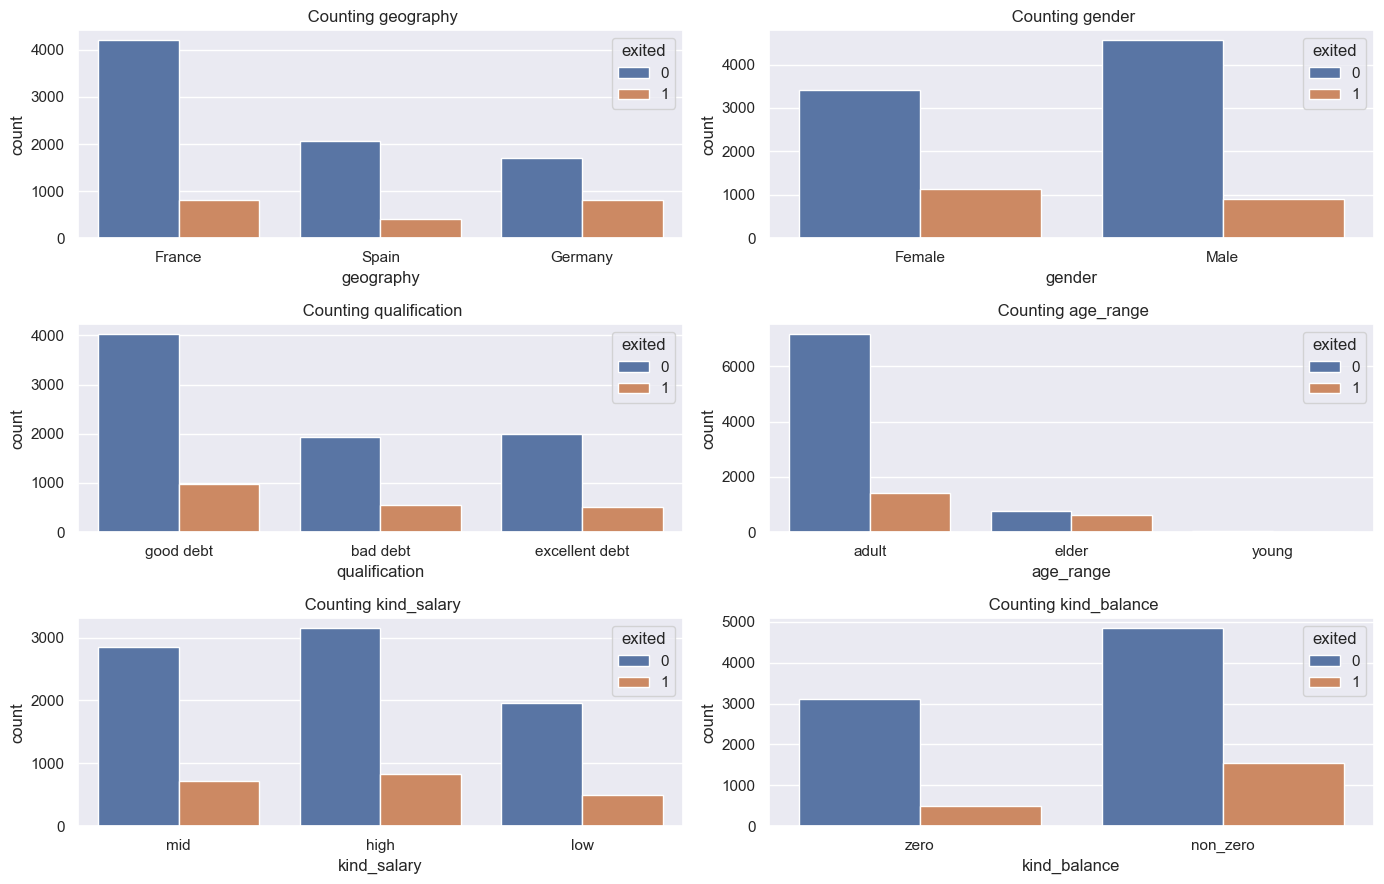

In [100]:
fig, axes = plt.subplots(3,2,figsize=(14,9))

for i, coluna in enumerate(cat_cols):
    pos_x, pos_y = divmod(i,2)
    sns.countplot(data = df2, x = coluna, hue = 'exited', ax = axes[pos_x, pos_y]);
    axes[pos_x, pos_y].set_title(" Counting {}".format(coluna), fontsize = 12);
plt.tight_layout();

- H1. Good and Excellent Debt are more concentrated in the ADULT range than others
- H2. Bad Debt are concentrated under 30-year
- H3. High Tenure is concentrated in Elder range
- H4. Under 35-year has more CreditCard than others
- H5. Churn is concentrated under 40-year
- H6. Churn is concentrated less than 3 Tenure
- H7. Churn is concentrated in Bad Debt than others
- H8. The Balance increase long the Tenure
- H9. Churn is concentrated in Active customers
- H10. Mean Spent Amount above 25k has more Churn
- H11. Who buys 1 product only has more Churn than others
- H12. Germany has more Churn than others


### - H1. Good and Excellent Debt are more concentrated in the ADULT range than others

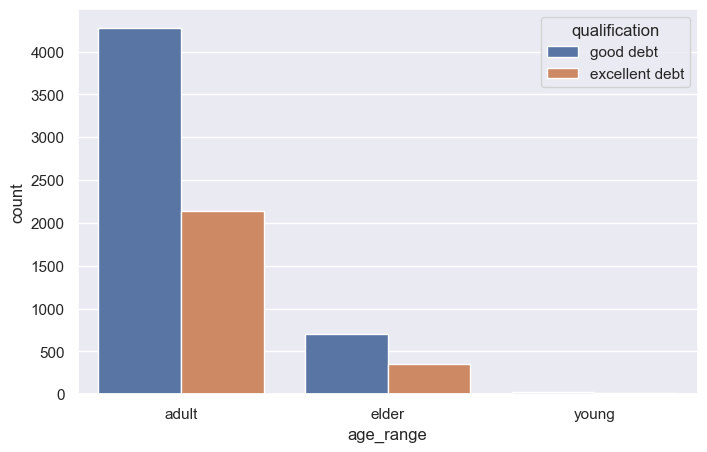

In [101]:
fig, axes = plt.subplots(1,1,figsize=(8,5))

aux = df2.loc[df2['qualification'].isin(['good debt','excellent debt'])]
sns.countplot(data = aux, x = 'age_range', hue = 'qualification', ax = axes);

### TRUE: Adult is responsible for the concentration of almost all Good/Excellent Debt

### - H2. Bad Debt are concentrated under 30-year

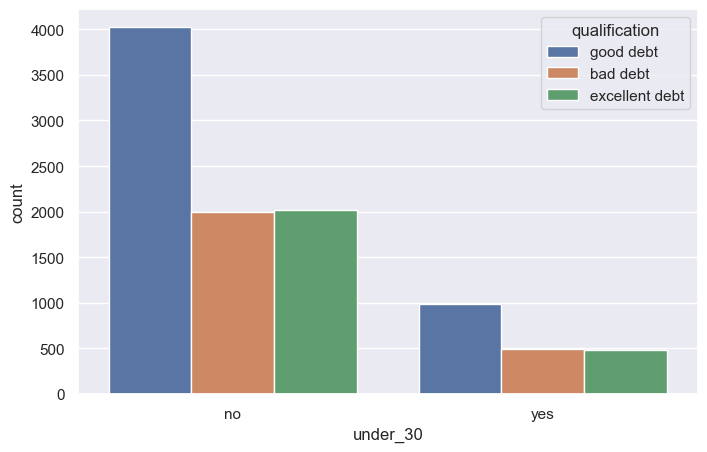

In [104]:
fig, axes = plt.subplots(1,1,figsize=(8,5))

aux = df2.copy()
aux['under_30'] = 'yes'
aux.loc[aux['age'] > 30, 'under_30'] = 'no'
sns.countplot(data = aux, x = 'under_30', hue = 'qualification', ax = axes);

### FALSE: Bad Debt is concentrated above 30-year

### - H3. High Tenure is concentrated in Elder range

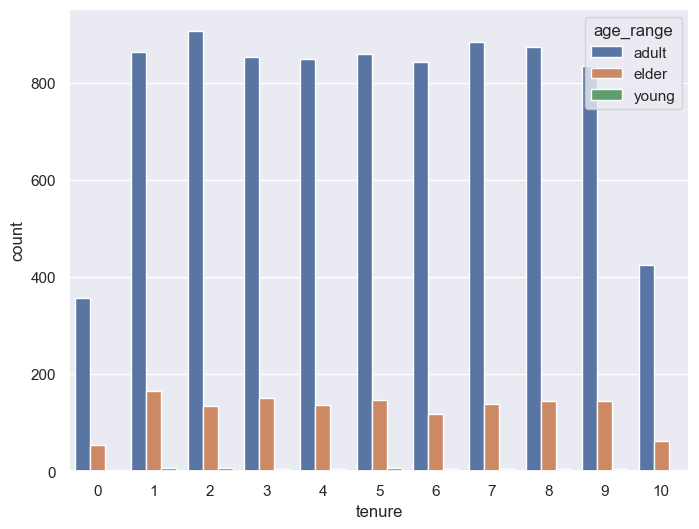

In [105]:
fig, axes = plt.subplots(1,1,figsize=(8,6))

sns.countplot(data = df2, x = 'tenure', hue = 'age_range', ax = axes);

### FALSE: The concentration is on ADULT

### - H4. Under 35-year has more CreditCard than others

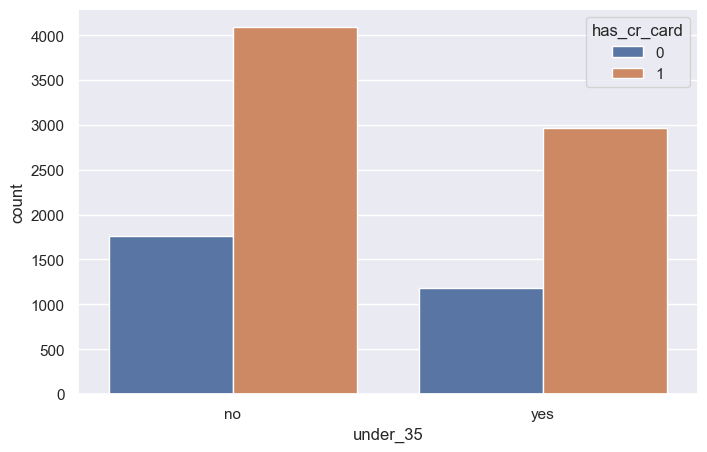

In [107]:
fig, axes = plt.subplots(1,1,figsize=(8,5))

aux = df2.copy()
aux['under_35'] = 'yes'
aux.loc[aux['age'] > 35, 'under_35'] = 'no'
sns.countplot(data = aux, x = 'under_35', hue = 'has_cr_card', ax = axes);

### FALSE: Above 35 has more Credit Card than under 35

### - H5. Churn is concentrated under 40-year

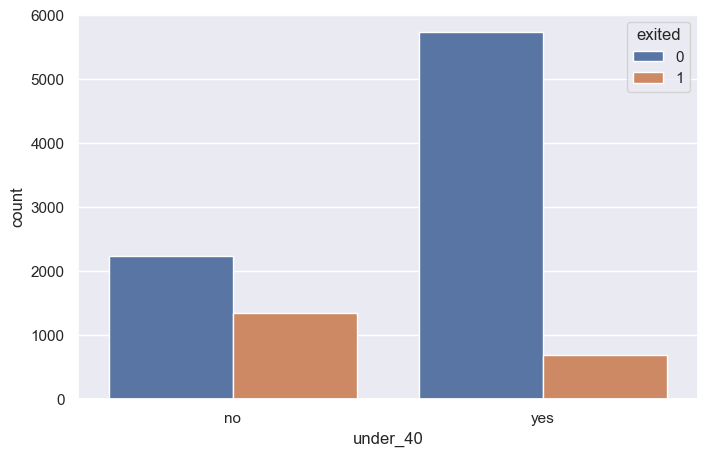

In [109]:
fig, axes = plt.subplots(1,1,figsize=(8,5))

aux = df2.copy()
aux['under_40'] = 'yes'
aux.loc[aux['age'] > 40, 'under_40'] = 'no'
sns.countplot(data = aux, x = 'under_40', hue = 'exited', ax = axes);

### FALSE: Above 40 has more CHURN than under 40

### - H6. Churn is concentrated less than 3 Tenure

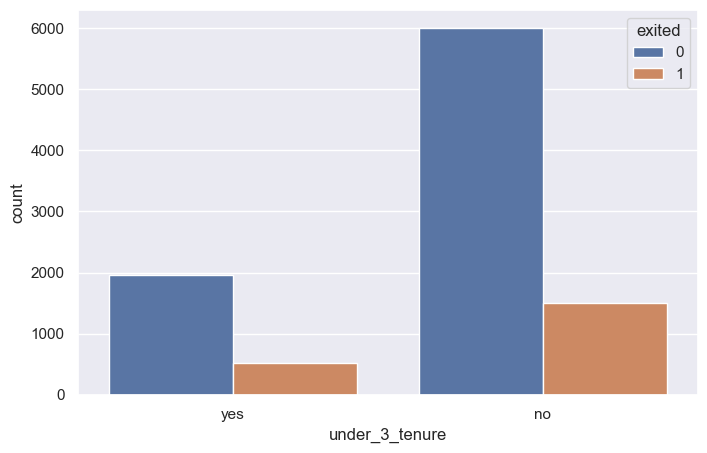

In [110]:
fig, axes = plt.subplots(1,1,figsize=(8,5))

aux = df2.copy()
aux['under_3_tenure'] = 'yes'
aux.loc[aux['tenure'] >= 3, 'under_3_tenure'] = 'no'
sns.countplot(data = aux, x = 'under_3_tenure', hue = 'exited', ax = axes);

### FALSE: Tenure above 3 has more Churn than below 3

### - H7. Churn is concentrated in Bad Debt than others

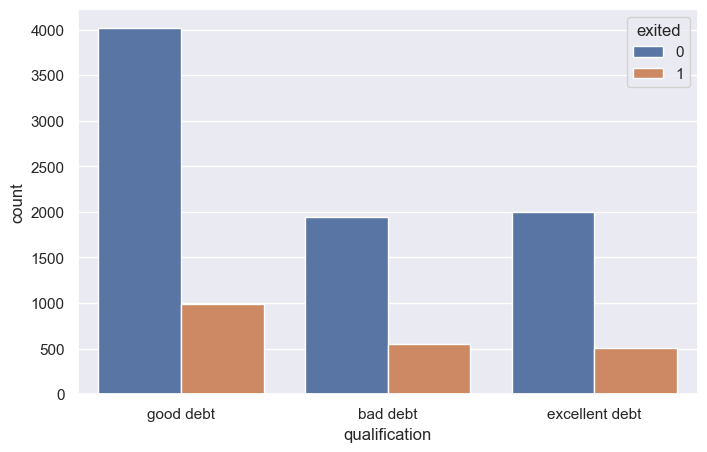

In [112]:
fig, axes = plt.subplots(1,1,figsize=(8,5))

sns.countplot(data = df2, x = 'qualification', hue = 'exited', ax = axes);

### FALSE: Good Debt has more Churn than Bad Debt

### - H8. The Balance increase long the Tenure

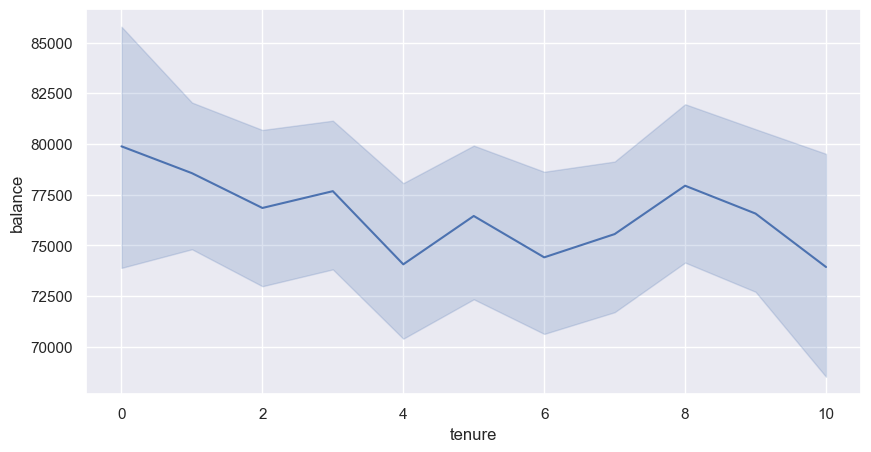

In [114]:
fig, axes = plt.subplots(1,1,figsize=(10,5))

aux = df2.copy()
sns.lineplot(data = aux, x = 'tenure', y = 'balance', ax = axes);

### FALSE: The Balance decrease along the Tenure

### - H9. Churn is concentrated in Active customers

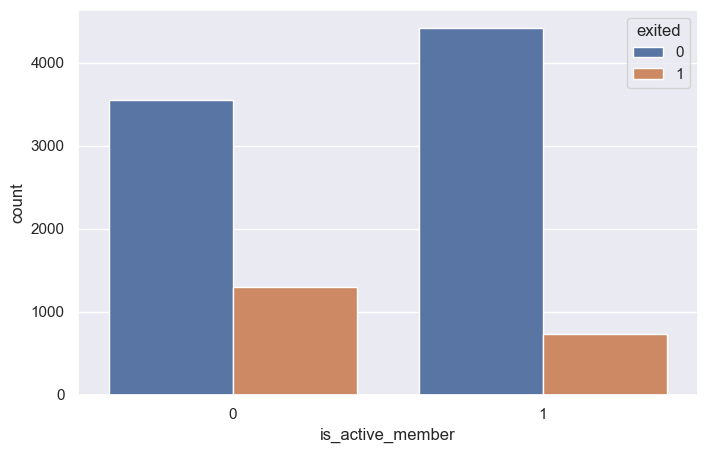

In [116]:
fig, axes = plt.subplots(1,1,figsize=(8,5))

sns.countplot(data = df2, x = 'is_active_member', hue = 'exited', ax = axes);

### FALSE: Churn is concentrated in non-Active Members

### - H10. Mean Spent Amount above 25k has more Churn

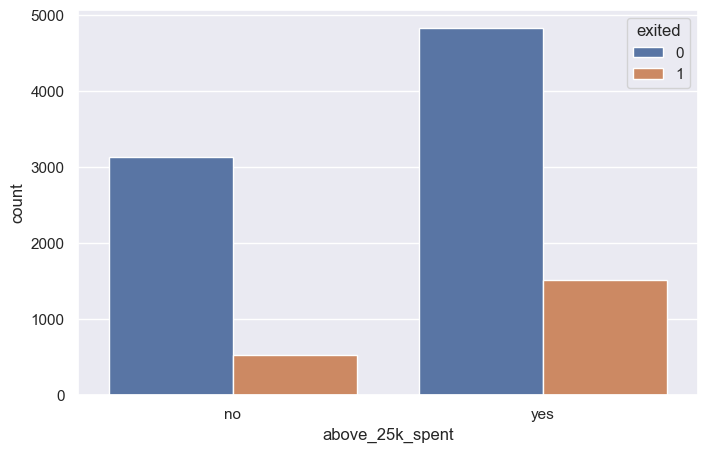

In [118]:
fig, axes = plt.subplots(1,1,figsize=(8,5))

aux = df2.copy()
aux['above_25k_spent'] = 'yes'
aux.loc[aux['mean_spent_product'] < 25000, 'above_25k_spent'] = 'no'
sns.countplot(data = aux, x = 'above_25k_spent', hue = 'exited', ax = axes);

### TRUE: The Mean Spent above $25k has more Churn values than values above 25k

### - H11. Who buys 1 product only has more Churn than others

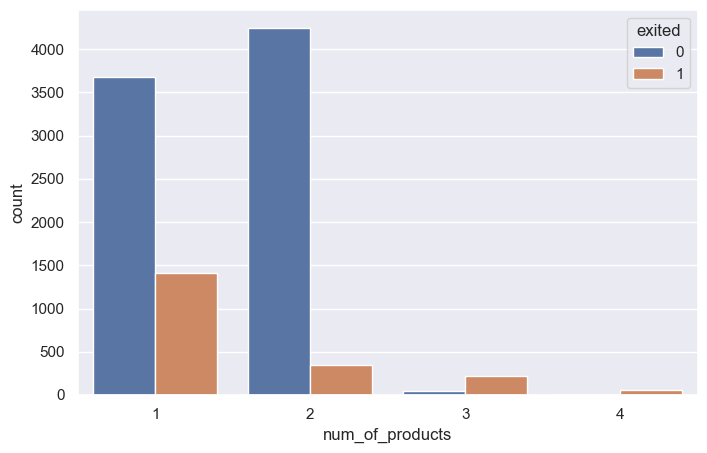

In [120]:
fig, axes = plt.subplots(1,1,figsize=(8,5))

aux = df2.copy()
sns.countplot(data = aux, x = 'num_of_products', hue = 'exited', ax = axes);

### TRUE: Who buys 1 product only has more Churn than others

### - H12. Germany has more Churn than others

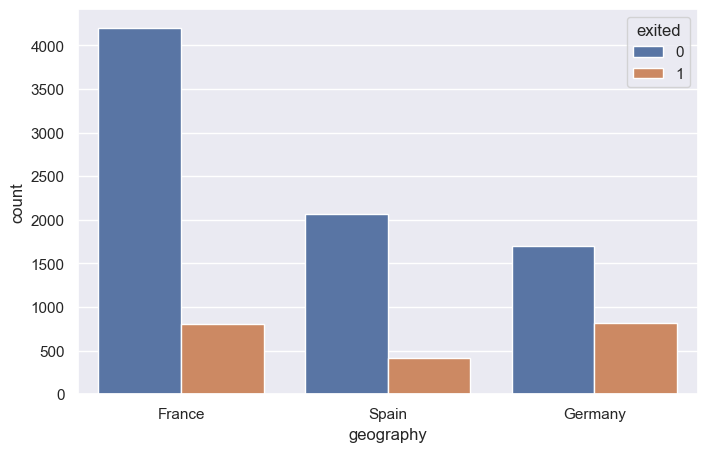

In [127]:
fig, axes = plt.subplots(1,1,figsize=(8,5))

aux = df2.copy()
sns.countplot(data = aux, x = 'geography', hue = 'exited', ax = axes);

In [128]:
aux.loc[aux['exited'] == 1,'geography'].value_counts()

Germany    814
France     810
Spain      413
Name: geography, dtype: int64

### TRUE: Germany has more Churn than others

C:\Users\pedro\AppData\Local\Temp\ipykernel_3356\536685591.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlations = df2.corr(method = 'pearson')


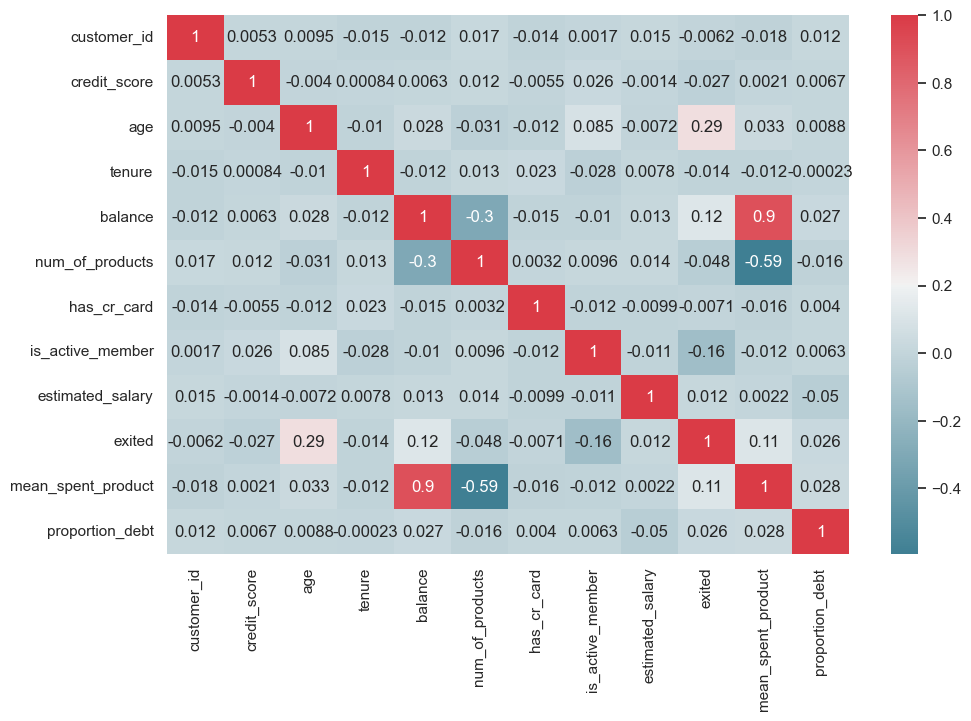

In [121]:
correlations = df2.corr(method = 'pearson')

fig, axes = plt.subplots(1,1,figsize=(11,7))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(correlations, ax = axes, cmap=cmap, annot = True);

The most relevant correlations where on variables which have dependencies each other

In [185]:
df3 = df2.copy()

In [186]:
df3.head()

,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,qualification,age_range,mean_spent_product,proportion_debt,kind_salary,kind_balance
0,15634602,Hargrave,619,France,Female,42,2,0.000,1,1,1,101348.880,1,good debt,adult,0.000,0.000,mid,zero
1,15647311,Hill,608,Spain,Female,41,1,83807.860,1,0,1,112542.580,0,good debt,adult,83807.860,0.745,mid,non_zero
2,15619304,Onio,502,France,Female,42,8,159660.800,3,1,0,113931.570,1,bad debt,adult,53220.267,1.401,mid,non_zero
3,15701354,Boni,699,France,Female,39,1,0.000,2,0,0,93826.630,0,good debt,adult,0.000,0.000,mid,zero
4,15737888,Mitchell,850,Spain,Female,43,2,125510.820,1,1,1,79084.100,0,excellent debt,adult,125510.820,1.587,mid,non_zero


## Scaling

In [187]:
num_cols_scale = ['credit_score', 'age', 'tenure', 'balance','num_of_products','estimated_salary','mean_spent_product', 'proportion_debt']
for coluna in num_cols_scale:
    mms = MinMaxScaler()
    df3[coluna] = mms.fit_transform(df3[coluna].values.reshape(-1, 1))
    joblib.dump(mms, '../references/mms_{}.pkl'.format(coluna))

## Categorical encoding

In [188]:
df3 = pd.get_dummies(df3, prefix =['geo','g','qua','ar','ks','kb'] ,
                     columns =['geography','gender','qualification','age_range','kind_salary','kind_balance'] )

In [189]:
df3.to_parquet(data_path + 'processed/churn_fe_encoded.parquet', index = False)